In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sn
import pickle

from matplotlib import pyplot as plt
from io import StringIO
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, roc_auc_score,f1_score, confusion_matrix, roc_curve

from tqdm.auto import tqdm
from sklearn.model_selection import KFold

In [2]:
df_listings_details = pd.read_csv('../data/listings_detailed.csv')
df_listings = pd.read_csv('../data/listings.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)

In [4]:
host_features = [
    'host_response_rate',    
    'host_acceptance_rate',
    'host_identity_verified',      
    'host_listings_count',   
    'host_is_superhost',
]

review_features = [
    'review_scores_rating',        
    'review_scores_cleanliness',   
    'review_scores_communication', 
    'review_scores_accuracy',      
    'number_of_reviews',           
    'number_of_reviews_ltm',       
    'reviews_per_month',           
]

listing_features = [
    'instant_bookable',            
    'calculated_host_listings_count', 
    'availability_30',             
]


categorical_features = [
    'room_type',                   
    'neighbourhood',      
]

all_features = host_features + review_features + listing_features + categorical_features


In [5]:
def normalize_rooms(df):
    unique_rooms = df['room_type'].unique()
    for g in unique_rooms:
        df[g] = df['room_type'].apply(lambda x: g in x)
    df = df.drop('room_type', axis=1)
    return df

In [6]:
def normalize_locations(df):
    unique_rooms = df['neighbourhood_grouped'].unique()
    for g in unique_rooms:
        df[g] = df['neighbourhood_grouped'].apply(lambda x: g in x)
    df = df.drop('neighbourhood_grouped', axis=1)
    df = df.drop('neighbourhood', axis=1)
    return df

In [7]:
def group_neighborhoods(df, min_count=300, neighborhood_col='neighbourhood'):
    room_counts = df[neighborhood_col].value_counts()
    neighborhoods_to_keep = room_counts[room_counts >= min_count].index.tolist()
    df['neighbourhood_grouped'] = df[neighborhood_col].apply(
        lambda x: x if x in neighborhoods_to_keep else 'Others'
    )
    return df

In [8]:
def normalize_tf_cols(df, column):
    df[column] = df[column].replace({'t': 1, 'f': 0}).astype(bool)
    return df

In [9]:
def fix_encoding(df_cleaned):
    encoding_map = {}
    for val in df_cleaned['neighbourhood'].unique():
        try:
            clean_val = val.encode("latin1").decode("utf-8", errors="ignore")
            encoding_map[val] = clean_val
        except (UnicodeEncodeError, AttributeError):
            encoding_map[val] = val
    df_cleaned['neighbourhood'] = df_cleaned['neighbourhood'].map(encoding_map)
    return df_cleaned

In [10]:
def data_cleanup(df_1, df_2):
    df_merged_listings = pd.concat([df_listings, df_listings_details], axis=1)
    df_merged_listings = df_merged_listings.loc[:, ~df_merged_listings.columns.duplicated()]
    df_cleaned = df_merged_listings[all_features].dropna() 
    df_cleaned['host_response_rate'] = df_cleaned['host_response_rate'].str.replace('%', '', regex=False).astype(float)
    df_cleaned['host_acceptance_rate'] = df_cleaned['host_acceptance_rate'].str.replace('%', '', regex=False).astype(float)
    df_cleaned = normalize_rooms(df_cleaned)
    df_cleaned = normalize_tf_cols(df_cleaned, 'instant_bookable')
    df_cleaned = normalize_tf_cols(df_cleaned, 'host_identity_verified')
    df_cleaned = normalize_tf_cols(df_cleaned, 'host_is_superhost')
    df_cleaned = fix_encoding(df_cleaned)
    df_cleaned.columns = df_cleaned.columns.str.replace('/','_')
    df_cleaned = group_neighborhoods(df_cleaned, 300, 'neighbourhood')
    df_cleaned = normalize_locations(df_cleaned)
    df_cleaned.columns = df_cleaned.columns.str.lower()
    df_cleaned.columns = df_cleaned.columns.str.replace(' ','_')
    return df_cleaned

In [11]:
df_cleaned = data_cleanup(df_listings, df_listings_details)

In [12]:
interested_features = all_features.copy()
interested_features.remove("room_type")
interested_features.remove("neighbourhood")
target = "host_is_superhost"

In [13]:
print(interested_features)
print(target)

['host_response_rate', 'host_acceptance_rate', 'host_identity_verified', 'host_listings_count', 'host_is_superhost', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_accuracy', 'number_of_reviews', 'number_of_reviews_ltm', 'reviews_per_month', 'instant_bookable', 'calculated_host_listings_count', 'availability_30']
host_is_superhost


In [14]:
df_full = df_cleaned[interested_features]
df_full_train, df_test = train_test_split(df_full,test_size=0.2,random_state=1)
df_train, df_val=train_test_split(df_full_train,test_size=0.25,random_state=1)

y_train = df_train.host_is_superhost.values
y_val = df_val.host_is_superhost.values
y_test = df_test.host_is_superhost.values

del df_train['host_is_superhost']
del df_val['host_is_superhost']
del df_test['host_is_superhost']

In [15]:
log_reg_model = LogisticRegression(solver='liblinear', C=1.0, max_iter=2000, random_state=42)

In [16]:
interested_features_train = interested_features.copy()
interested_features_train.remove("host_is_superhost")
dv_log_reg = DictVectorizer()

train_dict = df_train[interested_features_train].to_dict(orient='records')
X_train = dv_log_reg.fit_transform(train_dict)

val_dict = df_val[interested_features_train].to_dict(orient='records')
X_val = dv_log_reg.transform(val_dict)

In [17]:
len(df_full), len(df_train),len(df_val), len(df_test), np.shape(X_train), np.shape(X_val), len(train_dict), len(val_dict), len(y_train), len(y_val)

(8690, 5214, 1738, 1738, (5214, 14), (1738, 14), 5214, 1738, 5214, 1738)

In [18]:
log_reg_model.fit(X_train, y_train)
y_pred_val = log_reg_model.predict_proba(X_val)[:,1]

In [19]:
hit_decision = (y_pred_val >= 0.5).astype(int)

df_pred = pd.DataFrame()
df_pred['actual']=y_val
df_pred['probability']=y_pred_val
df_pred['prediction']=hit_decision.astype(int)
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [20]:
def returnAuc(y_val, y_pred_val):
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
    area =auc(fpr, tpr)
    return area

In [21]:
area = returnAuc(y_val,y_pred_val)
area

0.8232638264173504

In [22]:
def p_r_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['f1_score'] = 2 * ((df_scores['p'] * df_scores['r']) / (df_scores['p'] + df_scores['r']))
    
    return df_scores

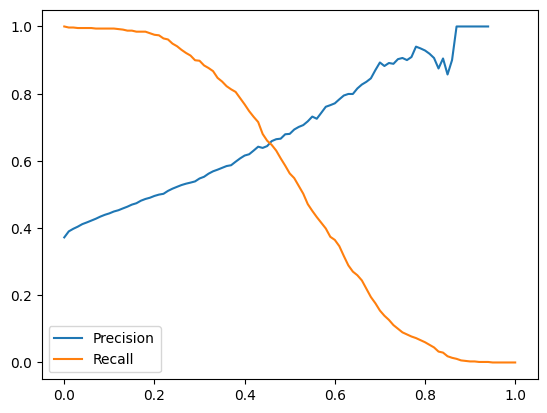

In [23]:
df_scores = p_r_dataframe(y_val, y_pred_val)
plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()

In [24]:
max = df_scores['f1_score'].max()
max
threshold = df_scores[df_scores['f1_score'] == df_scores['f1_score'].max()]['threshold']
threshold

33    0.33
Name: threshold, dtype: float64

In [25]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[interested_features_train].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(
                C=C,
                max_iter=5000,
                solver='lbfgs',           
                class_weight='balanced',
                random_state=42,
                tol=1e-4,               
                verbose=0
            )
    model.fit(X_train, y_train)
    
    return dv, model

In [26]:
def predict(df, dv, model):
    dicts = df[interested_features_train].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [27]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.host_is_superhost.values
        y_val = df_val.host_is_superhost.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.6f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.781 +- 0.010308
C=0.01 0.824 +- 0.008760
C=0.1 0.838 +- 0.006805
C=0.5 0.839 +- 0.006253
C=1 0.839 +- 0.006158
C=5 0.840 +- 0.006004
C=10 0.840 +- 0.005990


In [28]:
interested_features_ft = all_features.copy()
interested_features_ft.remove("host_is_superhost")
interested_features_ft.remove("room_type")
interested_features_ft.remove("neighbourhood")
target = ['host_is_superhost']

df_full_ft = df_cleaned[interested_features_ft]
df_full_train_ft, df_test_ft = train_test_split(df_full_ft,test_size=0.2,random_state=42)
df_train_ft, df_val_ft=train_test_split(df_full_train_ft,test_size=0.25,random_state=42)

print(len(df_full_ft), len(df_train_ft),len(df_val_ft), len(df_test_ft))

y_full_ft = df_cleaned[target]
y_full_train_ft, y_test_ft = train_test_split(y_full_ft,test_size=0.2,random_state=42)
y_train_ft, y_val_ft=train_test_split(y_full_train_ft,test_size=0.25,random_state=42)

print(len(y_train_ft), len(y_val_ft), len(y_test_ft))

8690 5214 1738 1738
5214 1738 1738


In [29]:
dv_log_reg = DictVectorizer()

train_dict_ft = df_train_ft[interested_features_ft].to_dict(orient='records')
X_train_ft = dv_log_reg.fit_transform(train_dict_ft)

val_dict_ft = df_val_ft[interested_features_ft].to_dict(orient='records')
X_val_ft = dv_log_reg.transform(val_dict_ft)

print(len(df_train_ft),len(df_val_ft), len(df_test_ft))
print(len(y_train_ft), len(y_val_ft), len(y_test_ft))
print(len(train_dict_ft), len(val_dict_ft))
print(np.shape(X_train_ft), np.shape(X_val_ft))


5214 1738 1738
5214 1738 1738
5214 1738
(5214, 14) (1738, 14)


In [30]:
best_c = 0.5 ## Arriving at this c from K_Fold
log__ft_reg_model = LogisticRegression(
                C=C,
                max_iter=5000,
                solver='lbfgs',           
                class_weight='balanced',
                random_state=42,
                tol=1e-4,               
                verbose=0
            )

param_grid = {
        'C' : [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    estimator = log__ft_reg_model,
    param_grid=param_grid,
    cv=5, 
    scoring='roc_auc',
    verbose=1)

In [31]:
print("Starting GridSearchCV.....")
grid_search.fit(X_train_ft, y_train_ft)
print("GridSearchCV Complete.")

Starting GridSearchCV.....
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

GridSearchCV Complete.


In [32]:
print("Results Analysis")
print(f"Best C Parameter Found: {grid_search.best_params_}")
print(f"Best cross-validation ROC AUC Score: {grid_search.best_score_:.4f}")

Results Analysis
Best C Parameter Found: {'C': 100}
Best cross-validation ROC AUC Score: 0.8401


In [33]:
df_cv_results = pd.DataFrame(grid_search.cv_results_)
cv_result_fields = ['param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']
print("Full Cross Validation Results")
print(df_cv_results[cv_result_fields])

Full Cross Validation Results
   param_C  mean_test_score  std_test_score  rank_test_score
0    0.001         0.777658        0.004463                6
1    0.010         0.820571        0.005285                5
2    0.100         0.837821        0.006010                4
3    1.000         0.839993        0.005259                3
4   10.000         0.840123        0.005027                2
5  100.000         0.840126        0.004976                1


In [34]:
final_classification_model = grid_search.best_estimator_
y_pred_final = final_classification_model.predict(X_val_ft)
y_prob_final = final_classification_model.predict_proba(X_val_ft)[:,1]

In [35]:
f1 = f1_score(y_val_ft, y_pred_final)
auc_val = roc_auc_score(y_val_ft, y_prob_final)
conf_matrix = confusion_matrix(y_val_ft, y_pred_final)
f1, auc_val, conf_matrix

(0.6902536715620827,
 0.8472294252555637,
 array([[757, 359],
        [105, 517]]))

In [36]:
log_reg_final_model = LogisticRegression(
                C=100,
                max_iter=5000,
                solver='lbfgs',           
                class_weight='balanced',
                random_state=42,
                tol=1e-4,               
                verbose=0
            )

In [37]:
log_reg_final_model.fit(X_train_ft, y_train_ft)
y_pred_final_val = log_reg_final_model.predict(X_val_ft)
y_proba_final_val = log_reg_final_model.predict_proba(X_val_ft)[:,1]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
f1 = f1_score(y_val_ft, y_pred_final_val)
auc_val = roc_auc_score(y_val_ft, y_proba_final_val)
conf_matrix = confusion_matrix(y_val_ft, y_pred_final_val)
f1, auc_val, conf_matrix

(0.6902536715620827,
 0.8472294252555637,
 array([[757, 359],
        [105, 517]]))

In [39]:
with open('../_models/classification_model.bin', 'wb') as f_out:
    pickle.dump((final_classification_model, dv_log_reg), f_out)